## 개요
- 네이버 영화 리뷰 감정 분석을 통해 한글 텍스트 분류를 실습해본다.
- 영어는 데이터가 많고, 참고 자료도 많지만, 한글은 그렇지 못한 편이 아쉽다. 
- 다행히 네이버 영화 리뷰는 공개가 되어 있기 때문에, 데이터를 다운받도록 한다. 
- 감정 분석은 우선 기본적으로 긍정 혹은 부정의 값을 가진다. 
- 데이터는 아래 URL에서 가져오도록 한다. 
  + https://github.com/e9t/nsmc

In [ ]:
from google.colab import drive # 패키지 불러오기 
from os.path import join  

ROOT = "/content/drive"     # 드라이브 기본 경로
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # 드라이브 기본 경로 Mount

/content/drive
Mounted at /content/drive


In [ ]:
MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/NLP/' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive/My Drive/Colab Notebooks/NLP/


In [ ]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/Colab Notebooks/NLP


In [ ]:
!ls

 bert_ckpt
 bert_gpt
 ch01_text_mining.ipynb
 ch02_bag_of_words
 ch02_bag_of_words_coo_csr.ipynb
 ch03_news_group_classification.ipynb
 ch04_sentiment_analysis.ipynb
 ch05_topic_modeling.ipynb
 ch06_opinion_review.ipynb
 ch07_similarity.ipynb
 ch08_kaggle_price_challenge.ipynb
'ch7_1_2_RNN_theory(1).ipynb'
'ch7_1_2_RNN_theory(2).ipynb'
 ch7_3_sentimentAnalysis.ipynb
'ch7_4_naturalLanguageGeneration(1).ipynb'
'ch7_4_naturalLanguageGeneration(2).ipynb'
 data
 gpt_ckpt
 gpt_ckpt.zip
 Korean


## 모듈 불러오기
- 데이터 분석을 위한 모듈을 불러온다. 

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

- 데이터를 불러오기 전에 각 데이터의 크기부터 확인하는 코드를 작성한다. 

In [ ]:
DATA_IN_PATH = './Korean/data_in/'
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
  if 'txt' in file:
    print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH+file) / 1000000, 2)) + 'MB')

파일 크기 : 
ratings_train.txt             14.63MB
ratings_test.txt              4.89MB
ratings.txt                   19.52MB


## 데이터 EDA
- 판다스를 이용해 학습 데이터를 불러온 후 확인해본다. 

In [ ]:
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header=0, delimiter='\t', quoting=3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- 한글 영화 리뷰 데이터의 경우 3개의 열(column)로 이뤄져 있고, 각 데이터의 인덱스, 리뷰 텍스트를 담은 `document`, 긍정/부정을 나타내는 라벨값을 가진다. 
- 먼저 전체 학습 데이터의 개수를 확인한다. 

In [ ]:
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 150000


- 이제 각 데이터에 대해 리뷰 길이를 확인해본다. 

In [ ]:
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

- 길이를 보면 19, 33, 17로 각 데이터의 길이 값을 가진다. 
- 이제 이 변수를 사용해 전체 데이터에 대해 길이에 대한 히스토그램을 그린다. 

Text(0, 0.5, 'Number of Review')

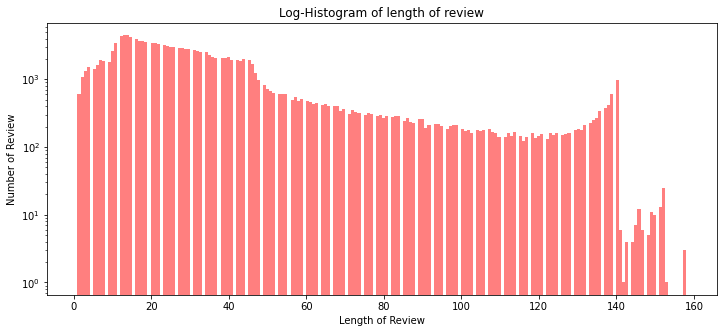

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of Review')
plt.ylabel('Number of Review')

- 박스 플롯도 생성을 해본다.

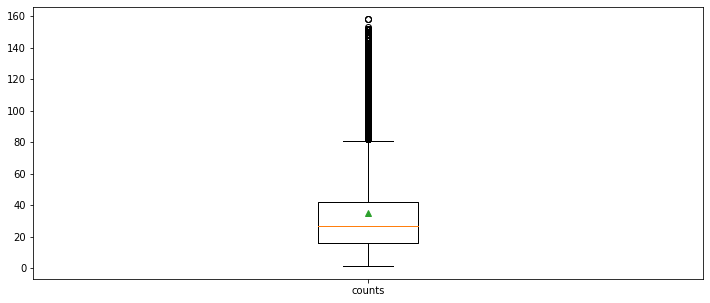

In [ ]:
plt.figure(figsize=(12,5))
plt.boxplot(train_length, labels=['counts'], showmeans=True)
plt.show()

- 이번에는 워드클라우드를 작업해본다. 
- 이 때, 한글폰트를 꼭 확인하도록 한다. 

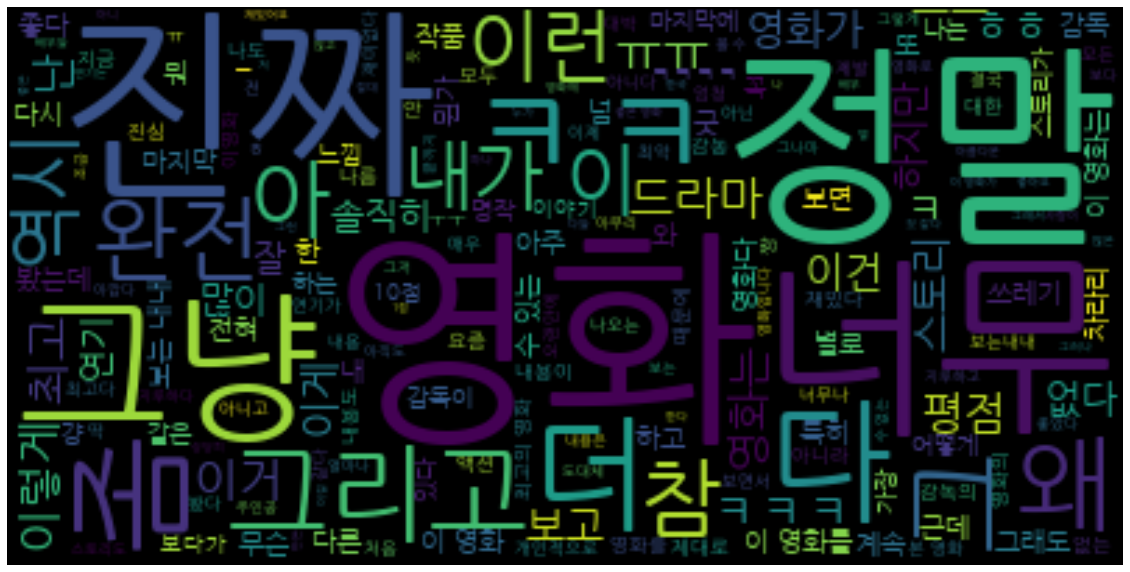

In [ ]:
train_review = [review for review in train_data['document'] if type(review) is str]
wordcloud = WordCloud(font_path=DATA_IN_PATH + 'NanumGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- 워드 클라우드를 보면 영화, 정말, 너무 등의 어휘가 가장 많이 사용된 것을 확인할 수 있다. 
- 이제 데이터의 긍정 및 부정을 나타내는 라벨값을 보여주도록 한다.

In [ ]:
print("긍정 리뷰 개수: {}".format(train_data['label'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['label'].value_counts()[0]))

긍정 리뷰 개수: 74827
부정 리뷰 개수: 75173


- 긍정과 부정의 개수가 약 300 정도 차이가 나지만 거의 비슷하게 분포를 보이고 있어 데이터를 그대로 사용해도 무방하다. 
- 이제 라벨값도 확인했으니 각 리뷰의 단어 수를 확인한다.

Text(0, 0.5, 'Number of reviews')

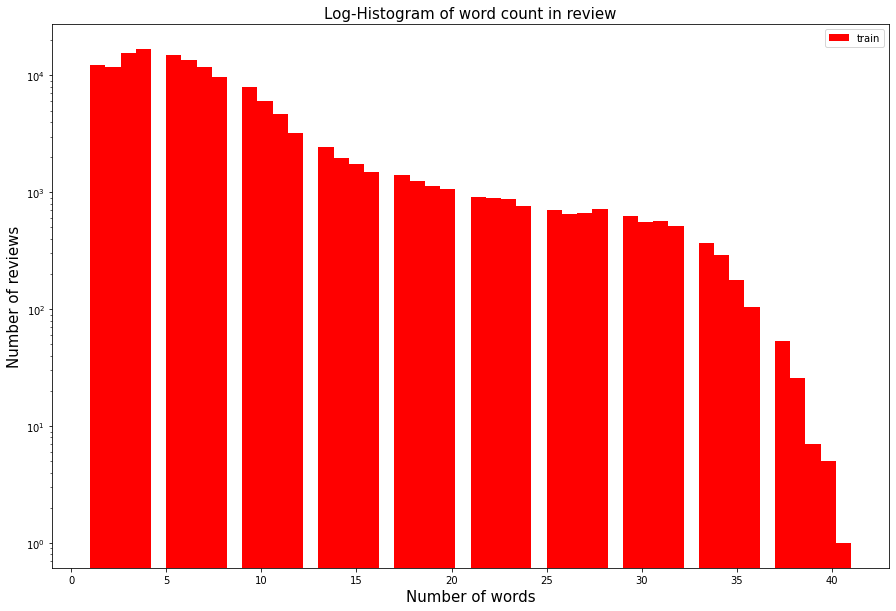

In [ ]:
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins = 50, facecolor='r', label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

- 길이의 경우 대부분 5개 정도에 분포돼 있는 것을 확인 할 수 있다. 30개 이후부터는 급격히 줄어드는 것을 확인할 수 있다.
- 이제 물픔표와 마침표가 있는 질문을 나눠서 구해보도록 한다.

In [ ]:
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x)) 
full_stop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x))

print("물음표가 있는 질문: {:.2f}%".format(qmarks * 100))
print("마침표가 있는 질문: {:.2f}%".format(full_stop * 100))

물음표가 있는 질문: 8.25%
마침표가 있는 질문: 51.76%


## 데이터 전처리
- 데이터 전처리 과정을 진행해본다. 
- 지난 시간에 배운 것처럼

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install --target=$my_path konlpy

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:14 http://ppa.launchpad.net/c

In [ ]:
import numpy as np
import pandas as pd
import re 
import json
from konlpy.tag import Okt
# from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header=0, delimiter='\t', quoting=3 )
print(train_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


- 정규표현식을 활용해 한글문자가 아닌 것들을 모두 제거한다. 

In [ ]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) 
print(review_text)

아 더빙 진짜 짜증나네요 목소리


- 보다시피 특수문자가 모두 제거가 되었다. 
- 이제 이러한 불용어를 제거하기 위해 문장을 단어로 나누도록 한다. 
  + `okt` 객체를 사용한다. 


In [ ]:
okt = Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['아', '더빙', '진짜', '짜증나다', '목소리']


- 불용어를 제거해야 하지만, 한글 불용어가 따로 정의돼 있는 파이썬 라이브러리는 없다. 
- 따라서, 직접 불용어 사전을 만들어야 하는 아쉬움이 있다. 
- 일단 아래와 같이 코드를 작업한다.

In [ ]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['더빙', '진짜', '짜증나다', '목소리']


- 위와 같이 불용어까지 제거하면 어느 정도 데이터가 정제됐다고 볼 수 있다. 
- 이제 하나의 전처리 함수를 만들도록 한다. 

In [ ]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
    return word_review

- 위 사용자 정의 함수를 토대로 이제 데이터 전처리를 진행하도록 한다.

In [ ]:
# 시간이 오래 걸리기 때문에 bench_mark를 확인해본다. 
import time
import datetime

def bench_mark(start):
  sec = time.time() - start
  times = str(datetime.timedelta(seconds=sec)).split(".")
  times = times[0]
  print(times)

In [ ]:
start = time.time()

stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in train_data['document']:
  
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가
        
bench_mark(start)

0:08:35


- 앞의 5개의 데이터를 확인해본다. 

In [ ]:
clean_train_review[:3] # 앞의 3개의 데이터 확인

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

- 오타가 있는 것이 보이지만, 일단 넘어가도록 한다. 
- 이제 해당 리뷰를 인덱스 벡터로 변환하면 되는데, 테스트 데이터도 동일하게 똑같이 적용하도록 한다. 

In [ ]:
test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt', header=0, delimiter='\t', quoting=3 )
clean_test_review = []

start = time.time()

for review in test_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

bench_mark(start)

0:02:57


- 텐서플로의 전처리 모듈을 사용하여 토크나이징 객체를 만든 후, 학습 데이터에 대해서만 적용하고 해당 객체를 사용해 두 데이터를 인덱스 벡터로 만든다. 
- 마지막으로 해당 데이터들을 패딩 처리하도록 한다. 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태
word_vocab["<PAD>"] = 0

MAX_SEQUENCE_LENGTH = 8 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

- 패딩 처리시 최대 길이를 8로 정했는데, 이는 이전 데이터 분석 과정에서 단어의 평균 개수가 대략 8개 정도였기 때문이다. 
- 학습 데이터와 평가 데이터에 대해 입력값과 라벨값을 만들었다면 해당 데이터들을 모델링 과정에서 사용할 수 있게 저장하도록 한다. 

In [ ]:
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

## 모델링
- 지난 시간에 지도학습을 통해 분류하는 모형의 `Input` 변수로 활용을 했다면, 이번에는 `CNN` 신경망을 활용해 모델링하는 것을 소개하도록 한다. 

### 학습 데이터 불러오기
- 모델링 과정에서 사용할 라이브러리를 모두 불러온다. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

- 전처리한 데이터를 모두 불러오도록 한다. 

### 랜덤 시드 고정
- 모델을 구현할 때 가장 중요한 것은 실험의 재현성

In [ ]:
DATA_IN_PATH = './Korean/data_in/'
DATA_OUT_PATH = './Korean/data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

- 이제 불러온 데이터를 모델에 적용하도록 하며, 학습 데이터의 일부를 검증 데이터로 분리해서 모델의 성능을 측정하도록 한다. 

### 파라미터 정의
- 모델에 필요한 하이퍼파라미터를 정의한다. 이 때, 모델 학습 설정, 모델 레이어 차원수 등으로 나누고 학습을 위한 배치 크기 등은 변수로 지정한다. 


In [ ]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

### 모델 클래스 
- 이제 모델 클래스를 구현한다.
- 조금 간단하게 구현하는 것을 클래스로 구현한 것이 특징이라고 할 수 있다. 



In [ ]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

### 모델 학습
- 이번 장의 초반부에 설명한 합성곱 신경망을 선언하는 부분과 같은 방식으로 진행한다. 

In [ ]:
model = CNNClassifier(**kargs)

model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

- `EarlyStopping` 기능과 모델 저장 방식을 지정하고, 모델을 검증하기 위한 검증 데이터도 `model.fit` 안에 있는 `validation_split`로 지정한 다음 학습을 시작한다. 

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./Korean/data_out/cnn_classifier_kr -- Folder already exists 



- 이제 모형을 학습하도록 한다. 

In [ ]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.7756
Epoch 1: val_accuracy improved from -inf to 0.82173, saving model to ./Korean/data_out/cnn_classifier_kr/weights.h5
264/264 [==============================] - 44s 147ms/step - loss: 0.4576 - accuracy: 0.7756 - val_loss: 0.3923 - val_accuracy: 0.8217
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8457
Epoch 2: val_accuracy improved from 0.82173 to 0.82907, saving model to ./Korean/data_out/cnn_classifier_kr/weights.h5
264/264 [==============================] - 38s 143ms/step - loss: 0.3524 - accuracy: 0.8457 - val_loss: 0.3845 - val_accuracy: 0.8291
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.8730
Epoch 3: val_accuracy did not improve from 0.82907
264/264 [==============================] - 37s 141ms/step - loss: 0.2998 - accuracy: 0.8730 - val_loss: 0.3923 - val_accuracy: 0.8257
Epoch 4/10
264/264 [====

### 학습 결과 시각화
- 모형 학습 결과가 잘 되는지 확인하기 위해 시각화 함수를 작성한다. 

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

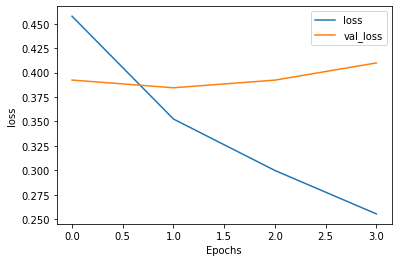

In [ ]:
plot_graphs(history, 'loss')

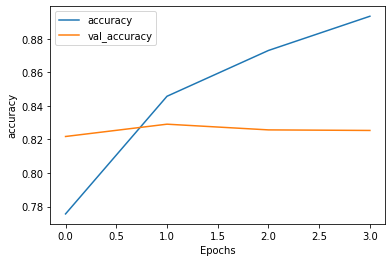

In [ ]:
plot_graphs(history, 'accuracy')

## 모델 테스트
- 테스트 데이터를 불러와서 바로 결과를 확인하도록 한다. 


In [ ]:
DATA_OUT_PATH = './Korean/data_out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 5s 3ms/step - loss: 0.3883 - accuracy: 0.8262


[0.3882630169391632, 0.826200008392334]